<img style="float: left; margin: 30px 15px 15px 15px;" src="https://pngimage.net/wp-content/uploads/2018/06/logo-iteso-png-5.png" width="300" height="500" /> 
    
    
### <font color='navy'> Simulación de procesos financieros. 

**Nombres:** Marco Antonio Ochoa Cárdenas y 

**Fecha:** 21/10/2021.

**Expediente** : if720072 
**Profesor:** Oscar David Jaramillo Zuluaga.
    
**Link Github**: https://github.com/Marcoif/Proyecto_Conjunto_MAOchoa_RBetancourt.git

# Tarea 8: Clase 22

# <font color = 'red'> Tarea: </font>

Replicar el procedimiento anterior para valoración de opciones 'call', pero en este caso para opciones tipo 'put' y además deben de comparar con los resultados teoricos del método de valuación de Black-Scholes (ecuación del principio de clase)

# Codigo del estudiante 1 

In [1]:
# Librerías necesarias
import pandas as pd
import numpy as np
import datetime
import yfinance as yf
import scipy.stats as st
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Descarga de precios de cierre históricos para la acción
# Creamos las funciones para hacer la opcion del tipo put

def options_yf(ticker):
    stock = yf.Ticker(ticker)
    calls, puts = {}, {}
    
    def options_yf_(n):
        nonlocal stock
        calls[stock.options[n]] = stock.option_chain(stock.options[n])[0]
        puts[stock.options[n]] = stock.option_chain(stock.options[n])[1]
    
    [options_yf_(n) for n in range(len(stock.options))]
    
    return calls, puts


    

In [21]:
# Todos los tipos de modelos que debemos comparar para el tipo put
#Creamos la funcion para poder simular los distintos metodos

def valuacionPut(ticker, fechaInicio, precioEjercicio, fechaExpiracion, rf, escenarios, 
                  metodo : "Simple, Logarítmicos, Normal, Histograma"):


    precios = yf.download(ticker, start = fechaInicio, end = None, progress = False)["Adj Close"]
    precioInicial = precios.iloc[-1]
    
    if metodo == "Simple":
        rendimiento = precios.pct_change().dropna()
        media = rendimiento.mean()
        volatilidad = rendimiento.std()
        
    elif metodo == "Logarítmicos":
        rendimiento = np.log(precios / precios.shift(1)).dropna()
        media = rendimiento.mean()
        volatilidad = rendimiento.std()
        
    elif metodo == "Normal":
        rendimiento = np.log(precios / precios.shift(1)).dropna()
        volatilidad = rendimiento.std()
        
    else:
        rendimiento = np.log(precios / precios.shift(1)).dropna()
        media = rendimiento.mean()
        volatilidad = rendimiento.std()
    
    
    
 

In [22]:
# Simulación de precios

def valuacionPut(ticker, fechaInicio, precioEjercicio, fechaExpiracion, rf, escenarios, 
                  metodo : "Simple, Logarítmicos, Normal, Histograma"):

    fechas = pd.date_range(start = datetime.date.today(), end = fechaExpiracion, freq = "B") 
    dias = len(fechas)
    
    if metodo == "Rendimientos simples" or metodo == "Rendimientos logarítmicos":
        Z = np.random.randn(dias, escenarios)
        rendimientosSimulados = pd.DataFrame(media + Z * volatilidad, index = fechas)
        
        if metodo == "Rendimientos simples":
            preciosSimulados = precioInicial * (rendimientosSimulados + 1).cumprod()
            preciosSimulados.iloc[0, :] = precioInicial 
    
        else:
            preciosSimulados = precioInicial * np.exp(rendimientosSimulados.cumsum())
            preciosSimulados.iloc[0, :] = precioInicial 
        
    elif metodo == "Modelo Normal":
        Z = np.random.randn(dias, escenarios)
        rendimientosSimulados = pd.DataFrame(volatilidad * Z + rf, index = fechas)
        preciosSimulados = precioInicial * np.exp(rendimientosSimulados.cumsum())
        preciosSimulados.iloc[0, :] = precioInicial
        
    else:
        y, x = np.histogram(rendimiento + rf - media, bins = 2000)
        y = y / np.sum(y)
        rendimientosSimulados_ = np.random.choice(x[1:], dias * escenarios, p = y)
        rendimientosSimulados = pd.DataFrame(rendimientosSimulados_.reshape((dias, escenarios)), index = fechas)
        preciosSimulados = precioInicial * np.exp(rendimientosSimulados.cumsum())
    
    

In [23]:
# Valuación
def valuacionPut(ticker, fechaInicio, precioEjercicio, fechaExpiracion, rf, escenarios, 
                  metodo : "Simple, Logarítmicos, Normal, Histograma"):

    if metodo == "Simple" or metodo == "Logarítmico":
        put = pd.DataFrame({"Prima" : np.exp(-media * dias) * np.fmax(precioEjercicio - preciosSimulados, 0).mean(axis = 1)}, 
                           index = fechas) 
    else:
        put = pd.DataFrame({"Prima" : np.exp(-rf * dias) * np.fmax(precioEjercicio - preciosSimulados, 0).mean(axis = 1)}, 
                           index = fechas) 
    
    intervaloConfianza = st.norm.interval(0.99, loc = put.iloc[-1].values[0], scale = st.sem(preciosSimulados.iloc[-1]))
    
    # Resultados
    resultados = [put.iloc[-1].values[0], intervaloConfianza[0], intervaloConfianza[1]]
    put.plot(figsize = (8, 5), title = metodo)
        
    return resultados
    

In [24]:
def blackScholesPut(ticker, fechaInicio, precioEjercicio, fechaExpiracion, rf):
    
    # Descarga de precios de cierre históricos para la acción
    precios = yf.download(ticker, start = fechaInicio, end = None, progress = False)["Adj Close"]
    precioInicial = precios.iloc[-1]
    
    # Rendimientos logarítmicos
    rendimiento = np.log(precios / precios.shift(1)).dropna()
    volatilidad = rendimiento.std()
    
    # Black and Scholes
    dias = len(pd.date_range(start = datetime.date.today(), end = fechaExpiracion, freq = "B"))
    
    d1 = (np.log(precioInicial / precioEjercicio) + (rf + 0.5 * volatilidad ** 2) * dias) / (volatilidad * np.sqrt(dias))
    d2 = (np.log(precioInicial / precioEjercicio) + (rf - 0.5 * volatilidad ** 2) * dias) / (volatilidad * np.sqrt(dias))
    
    put = precioEjercicio * np.exp(-rf * dias) * st.norm.cdf(-d2)  - precioInicial * st.norm.cdf(-d1) 
    
    return put

In [38]:
# Descarga de información de opciones financieras 
ticker = "NVDA"
fechaExpiracion = "2022-01-21"

calls , puts = options_yf(ticker)
puts = puts[fechaExpiracion][(puts[fechaExpiracion]["strike"] >= 340) & (puts[fechaExpiracion]["strike"] <= 370)]
puts

,contractSymbol,lastTradeDate,strike,lastPrice,bid,ask,change,percentChange,volume,openInterest,impliedVolatility,inTheMoney,contractSize,currency
155,NVDA220121P00340000,2021-11-19 20:43:44,340.0,30.55,27.90,30.95,-7.850002,-20.442715,92.0,128,0.464849,True,REGULAR,USD
156,NVDA220121P00345000,2021-11-19 16:56:55,345.0,35.05,29.45,34.15,-6.850002,-16.348454,7.0,128,0.467199,True,REGULAR,USD
157,NVDA220121P00350000,2021-11-19 20:28:41,350.0,36.85,35.30,37.25,-8.580002,-18.886202,255.0,831,0.465032,True,REGULAR,USD
158,NVDA220121P00355000,2021-11-19 20:07:13,355.0,40.58,39.00,40.65,-8.469997,-17.268090,35.0,124,0.465917,True,REGULAR,USD
159,NVDA220121P00360000,2021-11-19 16:15:28,360.0,48.50,42.50,44.30,-4.299999,-8.143938,27.0,154,0.469183,True,REGULAR,USD
160,NVDA220121P00362500,2021-11-19 20:57:18,362.5,45.95,44.35,46.05,-9.000000,-16.378527,8.0,143,0.468450,True,REGULAR,USD
161,NVDA220121P00365000,2021-11-19 20:44:03,365.0,47.70,46.20,47.95,-9.099998,-16.021126,47.0,119,0.470129,True,REGULAR,USD
162,NVDA220121P00370000,2021-11-19 19:56:24,370.0,51.90,49.90,51.65,-9.549999,-15.541088,18.0,137,0.469762,True,REGULAR,USD


In [39]:
# Valoración a través del Modelo de Black & Scholes
fechaInicio = "2016-11-15" 
indicePut = 158 
precioEjercicio = puts.loc[indicePut].strike
rf = 0.0018 / 360 
N = 10000 # 

primaReal = puts.loc[indicePut].lastPrice 
primaTeorica = blackScholesPut(ticker, fechaInicio, precioEjercicio, fechaExpiracion, rf) 
resultados = pd.DataFrame({"Prima Real" : primaReal, "Prima Teórica B&S" : primaTeorica}, 
                         index = ["Put: K = " + str(precioEjercicio) + ", Vencimiento = " + fechaExpiracion])

resultados["% Error relativo (prima real)"] = np.round(abs(primaTeorica - primaReal) / primaReal * 100, 2)
resultados

,Prima Real,Prima Teórica B&S,% Error relativo (prima real)
"Put: K = 355.0, Vencimiento = 2022-01-21",40.58,41.405808,2.04


,Prima,Límite inferior (99% confianza),Límite superior (99% confianza),% Error relativo (prima real),% Error relativ (prima teórica B&S)
Rendimientos simples,21.086337,19.181851,22.990823,48.04,49.07
Rendimientos logarítmicos,22.084051,20.174732,23.993369,45.58,46.66
Modelo Normal,37.602952,35.858940,39.346964,7.34,9.18
Histograma,36.818845,35.099177,38.538513,9.27,11.08


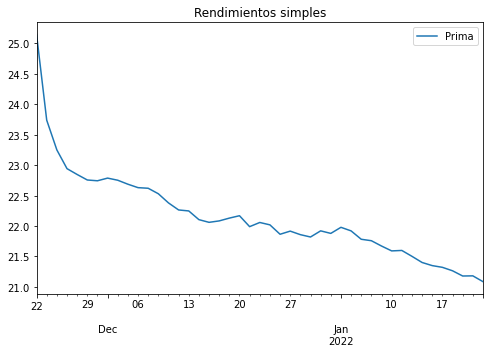

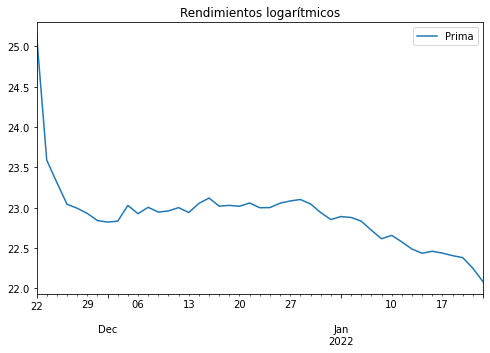

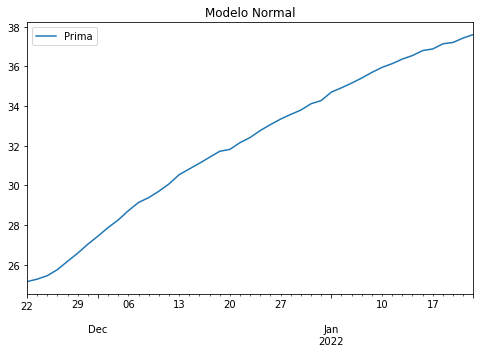

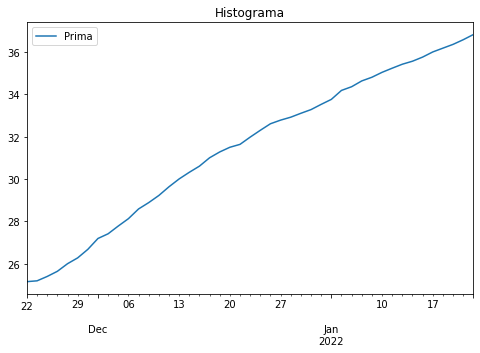

In [41]:
# Valoración a través de distintos métodos

metodos = ["Rendimientos simples", "Rendimientos logarítmicos", "Modelo Normal", "Histograma"]
primas = pd.DataFrame([valuacionPut(ticker, fechaInicio, precioEjercicio, fechaExpiracion, rf, N, metodo) 
                       for metodo in metodos],
                       columns = ["Prima", "Límite inferior (99% confianza)", "Límite superior (99% confianza)"], 
                       index = metodos)

primas["% Error relativo (prima real)"] = np.round(abs(primas["Prima"] - primaReal) / primaReal * 100, 2)
primas["% Error relativO (prima teórica B&S)"] = np.round(abs(primas["Prima"] - primaTeorica) / primaTeorica * 100, 2)
primas
    



Podemos decir como conclusion que como el metodo simple y el kogaritmico toman la tasa de descuento, ests simulaciones se ven mas afectadas ya que no es certero al mercado, y en cambio el metodo normal con el histograma son los mejores metodos ya que son los que mas se acercan al valor real del contrato

# Codigo del estudiante 2